In [27]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_quittime import RPS_quittime  
from rps_simulation.learning_curves import exponential_learning, logistic_learning # learonning curves
from rps_simulation.forgetting_curves import exponential_forgetting  # forgetting curves
from rps_simulation.practice_rate import simple_linear_rate  # simple linear rate
from rps_simulation.waiting_times import exponential_waiting_time  # exp waiting time distributi
from rps_simulation import display_progress

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Colour codes for concave and sigmoid curves:
concave_colour = '#466be8'
sigmoid_colour = '#f77150'

plot_dpi = 300 #dpi at which plots will be saved


np.random.seed(10) #setting seed for reproducible results 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In the RPS model with a logistic learning curve, experts have an inherent probability of quitting, defined as   

since there is a non-zero probability of waiting too long, resulting in a a lot of forgetting. If this value is low enough, they may never recover. Specifically:

$$ \Delta t \sim \text{Exp}(\lambda)$$
and,
$$ f_{\Delta t}(t) = \lambda e^{-\lambda t}  $$

Where,  $f_{\Delta t}(t)$ is the probability distribution function of the waiting times. 




In [19]:

## Defining the learning, forgetting and practice functions:

# Initializing the RPS_core class:
sample_concave = RPS_quittime(learning_func = exponential_learning(alpha=0.2),
                    forgetting_func = exponential_forgetting(forgetting_rate=0.2),
                    practice_rate_func = simple_linear_rate(a=0.2, b=5),
                    waiting_time_dist = exponential_waiting_time,
                    initial_skill=0.1, initial_practice_rate=1, 
                    quit_thresh=20, max_time=1000)


# run simulation:
sample_concave.run_simulation()




In [20]:
ps = sample_concave.practice_times
ss = sample_concave.skill_levels


In [21]:
sample_concave.quit

0

## Long Timescale Quitting in RPS Model

We expect no quitting in

### 1. Exponential Case:


In [22]:
n_sims = 100

quit_exp = [] # binary list storing if quit or not
n_prac_exp = [] # number of pracytice events
s_final_exp = [] # final skill
prac_final_exp = []
for i in range(n_sims):
    tmp_sim = RPS_quittime(learning_func = exponential_learning(alpha=0.2),
                    forgetting_func = exponential_forgetting(forgetting_rate=0.2),
                    practice_rate_func = simple_linear_rate(a=0.2, b=5),
                    waiting_time_dist = exponential_waiting_time,
                    initial_skill=0.1, initial_practice_rate=1, 
                    quit_thresh=10, max_time=1000)

    tmp_sim.run_simulation()
    quit_tmp = tmp_sim.quit # quit?
    quit_exp.append(quit_tmp)
    
    n_prac_exp.append(len(tmp_sim.practice_times)-2)
    s_final_exp.append(tmp_sim.final_skill)    
    #prac_final_exp.append(tmp_sim.practice_times[-2])
    prac_final_exp.append(tmp_sim.career_length)
    
    # Display Porgressbar:
    display_progress(i+1, n_sims)

exp_quit = {'quit': quit_exp,
            'n_prac': n_prac_exp,
            's_final': s_final_exp,
            'prac_final': prac_final_exp
           } 

# Save csv file of quit data: 
df_exp_quit = pd.DataFrame(exp_quit)
df_exp_quit.head(10)
df_exp_quit.to_csv('../data/df_exp_quit.csv')

# Quit percent:
exp_quit_perc = np.round(sum(df_exp_quit['quit']==1)*100/n_sims, 2)
print('Total quit percent in exponential case: '  + str(exp_quit_perc))

Total quit percent in exponential case: 0.0


Thus, there are no quittings seen in the exponential case. 

### 2. Sigmoid Case:

In [23]:
n_sims = 5000

quit_log = [] # binary list storing if quit or not
n_prac_log = [] # number of pracytice events
s_final_log = [] # final skill
prac_final_log = [] # stores career lengths
for i in range(n_sims):
    tmp_sim = RPS_quittime(learning_func = logistic_learning(alpha=0.4),
                    forgetting_func = exponential_forgetting(forgetting_rate=0.2),
                    practice_rate_func = simple_linear_rate(a=0.2, b=5),
                    waiting_time_dist = exponential_waiting_time,
                    initial_skill=0.1, initial_practice_rate=1, 
                    quit_thresh=10, max_time=1000)

    tmp_sim.run_simulation()
    quit_tmp = tmp_sim.quit # quit?
    quit_log.append(quit_tmp)
    
    n_prac_log.append(len(tmp_sim.practice_times)-2)
    s_final_log.append(tmp_sim.final_skill)    
    prac_final_log.append(tmp_sim.career_length)

    # Display Porgressbar:
    display_progress(i+1, n_sims)

# Make dict for saving:
log_quit = {'quit': quit_log,
            'n_prac': n_prac_log,
            's_final': s_final_log,
            'prac_final': prac_final_log
            }

# Save csv file of quit data: 
df_log_quit = pd.DataFrame(log_quit)
display(df_log_quit.head(5))
df_log_quit.to_csv('../data/df_log_quit.csv')

# Quit percent:
log_quit_perc = np.round(sum(df_log_quit['quit']==1)*100/n_sims, 2)
print('Total quit percent in logistic case: '  + str(log_quit_perc))

,quit,n_prac,s_final,prac_final
0,1,20,0.007938,44.529873
1,0,3530,0.864090,1000.000000
2,1,17,0.001918,41.517284
3,0,3494,0.855677,1000.000000
4,0,3521,0.866870,1000.000000


Total quit percent in logistic case: 18.26


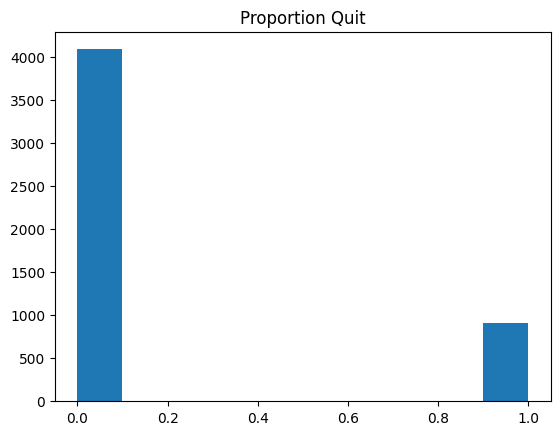

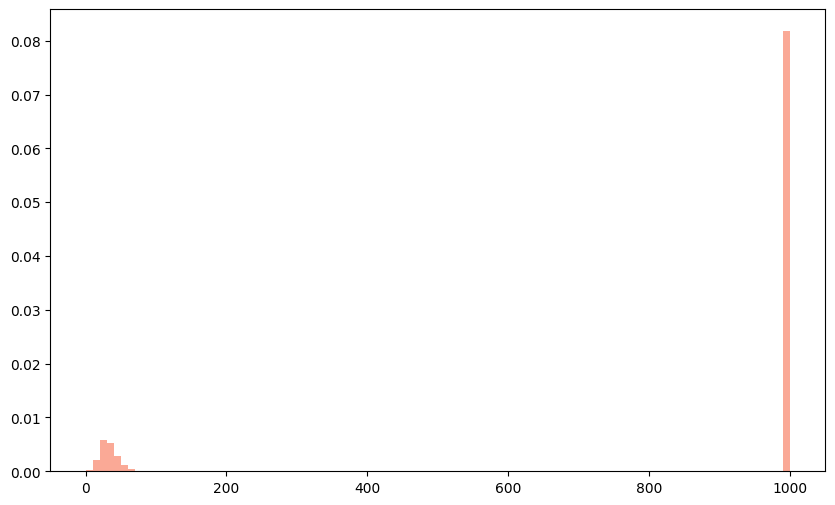

In [24]:
# df_log_quit.head(10)

plt.hist(quit_log)
plt.title('Proportion Quit')
plt.show()


# see quit times distribution
plt.figure(figsize=( 10,6))
plt.hist(prac_final_log, bins=100, density=True, alpha=0.6, color=sigmoid_colour)
plt.show()


### 3. Plot - Distribution of Career Lengths:

In [25]:
#df_exp_quit['Learning Curve'] = 'Exponential'
df_log_quit['Learning Curve'] = 'Logistic'

df_rps_sim  = pd.concat([df_exp_quit, df_log_quit])
df_rps_sim.head()




,quit,n_prac,s_final,prac_final,Learning Curve
0,0,3385,0.767674,1000.0,NaN
1,0,3355,0.763800,1000.0,NaN
2,0,3303,0.791722,1000.0,NaN
3,0,3359,0.793919,1000.0,NaN
4,0,3284,0.779100,1000.0,NaN


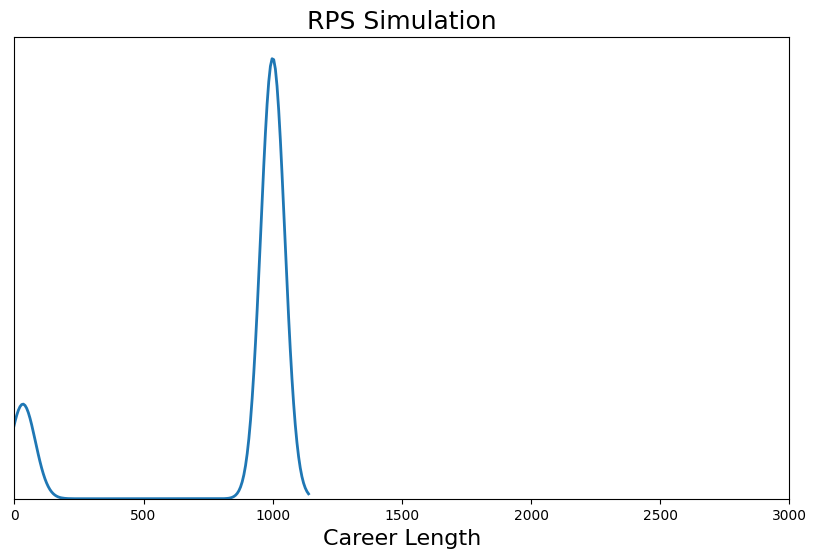

In [28]:
sigmoid_colour = '#f77150'
concave_colour = '#466be8'
max_time = 3000 # make sure it matches the simulation parameter above

plt.figure(figsize=( 10,6))
ax = sns.kdeplot(data=df_log_quit, 
            x='prac_final', 
            #hue='Learning Curve', 
            fill=False,
            alpha=1,
            linewidth=2,
            bw_adjust=0.68)
           # palette=[concave_colour, sigmoid_colour])


#sns.move_legend(ax, 'upper left')
#plt.setp(ax.get_legend().get_texts(), fontsize=12) # legend txt settings
#plt.setp(ax.get_legend().get_title(), fontsize=14) # legend title settings

plt.xlabel('Career Length', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('RPS Simulation', fontsize=18)
plt.xlim([0, max_time])
plt.yticks([])

#plt.savefig('../plots/rps_sim_carlen_compare.jpg', dpi=512)
plt.show()

## Appendix
Formula to set suitable $T_{th}$ quit threshold:
$$ T_{th} = \frac{\ln(N)}{\beta} $$
where, 
* $N$ = factor by which skill diminishes at quit vs. at last practice event
* $T_{th}$ = quit threshold to set in sim
* $\beta$ = forgetting rate



In [29]:
beta = 0.2
N_factor = 100 # we want the skill to reduce by 100 times after forgetting.  
np.log(N_factor)/beta

23.025850929940457